In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import copy
import yaml
import datetime

from simulator_external.simulator.simulator import *
from simulator_external.simulator.load_data import load_md_from_file
from stoikov import StoikovStrategy
from simulator_external.simulator.get_info import get_metrics, md_to_dataframe

# Stoikov strategy

Article: [Stoikov 2008] Avellaneda, M., & Stoikov, S. (2008). High-frequency trading in a limit order book. Quantitative Finance, 8(3), 217-224.

**1. Reservation price**
$$ r(s, t) = s - q \gamma \sigma^2 (T-t). $$

- $s$ is mid-price.
- $q$ is position size in base asset.
- $T$ is terminal time.
- $t$ is current time.
- $\sigma$ is volatiliaty of standard Brownian motion ($dS = \sigma dW$), by which the price is modeled in this article.
- $\gamma$ -- risk aversity.

$\sigma$ and $\gamma$ are parameters of the strategy.

**2. Spread**

$$ \delta^a + \delta^b = \gamma\sigma^2(T-t) + \frac{2}{\gamma} \log\left(1 + \frac{\gamma}{k}\right).$$

Here $k = \alpha K$, where
- $\alpha$ is from $f^Q(x) \propto x^{-1-\alpha}$ -- density of market order size (formula 9 from [Stoikov 2008]);
- $K$ is from $\Delta p \propto K^{-1} \log(Q)$ (formulas 11, 12 from [Stoikov 2008]).

# Backtesting functions

In [5]:
def my_round(x, ndigits):
    return round(float(x), ndigits)

def get_metrics_numeric(metrics):
    metrics_numeric = {
        'Final PnL':    my_round(metrics['worth_quote'].iloc[-1], 2),
        'Final volume': my_round(metrics['volume'].iloc[-1], 3),
        'Base balance': {
            'min':    my_round(metrics['base_balance'].min(), 3),
            'max':    my_round(metrics['base_balance'].max(), 3),
            'median': my_round(metrics['base_balance'].median(), 3),
        },
        'Quote balance': {
            'min':    my_round(metrics['quote_balance'].min(), 2),
            'max':    my_round(metrics['quote_balance'].max(), 2),
            'median': my_round(metrics['quote_balance'].median(), 2),
        }
    }
    return metrics_numeric

def backtest(md, sim_params: dict, strat_params: dict, fee: float) -> Tuple[pd.DataFrame, Dict]:
    """Run backtest and return results.
    Args:
        md: Parameter `md` (market data) for `Sim` constructor.
        sim_params: All parameters for `Sim` constructor, except `md`
        strat_params: All parameters for StoikovStrategy constructor, except `sim`.
        fee: Parameter `fee` for `get_metrics()` function.
    Returns:
        Simulation metrics in form of time series and single quantities.
    """
    sim = Sim(md, **sim_params)
    strategy = StoikovStrategy(sim, **strat_params)
    trades_list, md_list, updates_list, all_orders = strategy.run()
    metrics = get_metrics(updates_list, fee=fee)
    metrics_numeric = get_metrics_numeric(metrics)
    return metrics, metrics_numeric

In [6]:
def plot_metrics(metrics, metrics_numeric, asset, title=''):
    """Visualize backtesting results"""
    fig = make_subplots(rows=5, cols=1, row_heights=[0.3, 0.3, 0.2, 0.2, 0.2], shared_xaxes=True, vertical_spacing=0.005)
    fig.add_trace(go.Scatter(
        name='PnL',
        x=metrics['receive_ts'],
        y=metrics['worth_quote'],
        line=dict(color=px.colors.qualitative.Plotly[0]),
        showlegend=False
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        name='Mid-price',
        x=metrics['receive_ts'],
        y=metrics['mid_price'],
        line=dict(color=px.colors.qualitative.Plotly[5]),
        showlegend=False
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        name='Volume',
        x=metrics['receive_ts'],
        y=metrics['volume'],
        line=dict(color=px.colors.qualitative.Plotly[2]),
        showlegend=False
    ), row=3, col=1)

    fig.add_trace(go.Scatter(
        name='Base balance',
        x=metrics['receive_ts'],
        y=metrics['base_balance'],
        line=dict(color=px.colors.qualitative.Plotly[3]),
        showlegend=False
    ), row=4, col=1)

    fig.add_trace(go.Scatter(
        name='Quote balance',
        x=metrics['receive_ts'],
        y=metrics['quote_balance'],
        line=dict(color=px.colors.qualitative.Plotly[4]),
        showlegend=False
    ), row=5, col=1)

    metrics_numeric_txt = yaml.dump(metrics_numeric, default_flow_style=False, sort_keys=False).replace('\n', '<br>')
    fig.add_annotation(text=metrics_numeric_txt,
                       xref='paper', yref='paper', x=1, y=0.9,
                       align='left', font={'family': 'monospace'})

    title += f'<br>Backtest on {asset}'

    fig.update_layout(width=1000, height=1400,
                      title=title, xaxis5_title='Receive time',
                      yaxis1_title='PnL (account worth in quote asset)', yaxis2_title='Mid-price',
                      yaxis3_title='Trade volume', yaxis4_title='Base asset balance',
                      yaxis5_title='Quote asset balance')
    fig.update_traces(xaxis='x5')
    fig.update_xaxes(showspikes=True, spikemode='across', spikedash='dot', spikethickness=2)
    fig.update_yaxes(showspikes=True, spikemode='across', spikedash='dot', spikethickness=2)
    return fig

# Run the backtesting

The data is BTCUSDT Perpetural Futures.

In [4]:
MARKET_DATA_PATH = '../../data/'

In [7]:
MIN_TS = pd.Timestamp('2022-06-23 15:35:00')
MAX_TS = pd.Timestamp('2022-06-23 19:00:00')

In [8]:
md = load_md_from_file(MARKET_DATA_PATH, MIN_TS, MAX_TS)

In [9]:
sim_params = {
    'execution_latency': 10_000_000,
    'md_latency': 10_000_000
}
strat_params = {
    'gamma': 0.01,
    'k': 0.8,
    'sigma': 1,
    'terminal_time': False,
    'adjust_delay': 100_000_000,
    'order_size': 0.001,
    'min_order_size': 0.001,
    'precision': 2
}
FEE = 0.0

  0%|          | 0/1040571 [00:00<?, ?it/s]

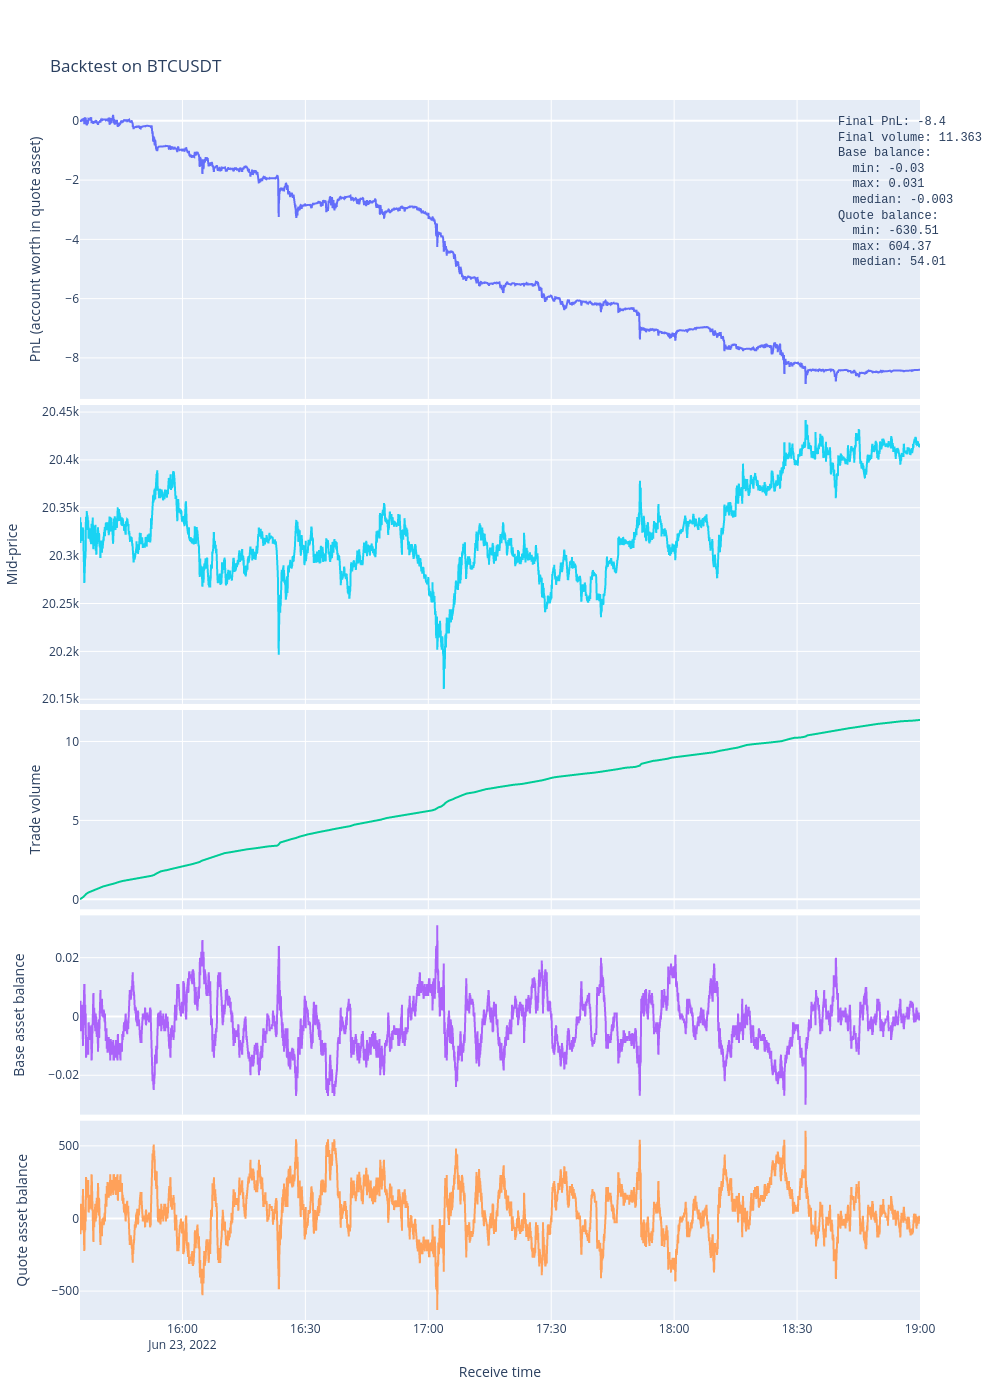

In [10]:
metrics, metrics_num = backtest(md, sim_params, strat_params, fee=FEE)
fig = plot_metrics(metrics[::60], metrics_num, asset='APPLUSDT')
fig.show(renderer='png')

Running on the simulator, the strategy obtains ~10 APPL of trading volume in 3.5 hours, while the PnL is only -8 dollars. The balances in BTC and USDT are oscillating around zero with maximum deviation of around 500 dollars.

## Compare strategy with and without terminal time

In [11]:
MIN_TS = pd.Timestamp('2022-06-23 15:35:00')
MAX_TS = pd.Timestamp('2022-06-23 19:00:00')

In [12]:
md = load_md_from_file(MARKET_DATA_PATH, MIN_TS, MAX_TS)

In [13]:
sim_params = {
    'execution_latency': 10_000_000,
    'md_latency': 10_000_000
}
strat_params = {
    'gamma': 0.01,
    'k': 0.8,
    'sigma': 1,
    'terminal_time': None,
    'adjust_delay': 100_000_000,
    'order_size': 0.001,
    'min_order_size': 0.001,
    'precision': 2
}
FEE = 0.0

  0%|          | 0/1040571 [00:00<?, ?it/s]

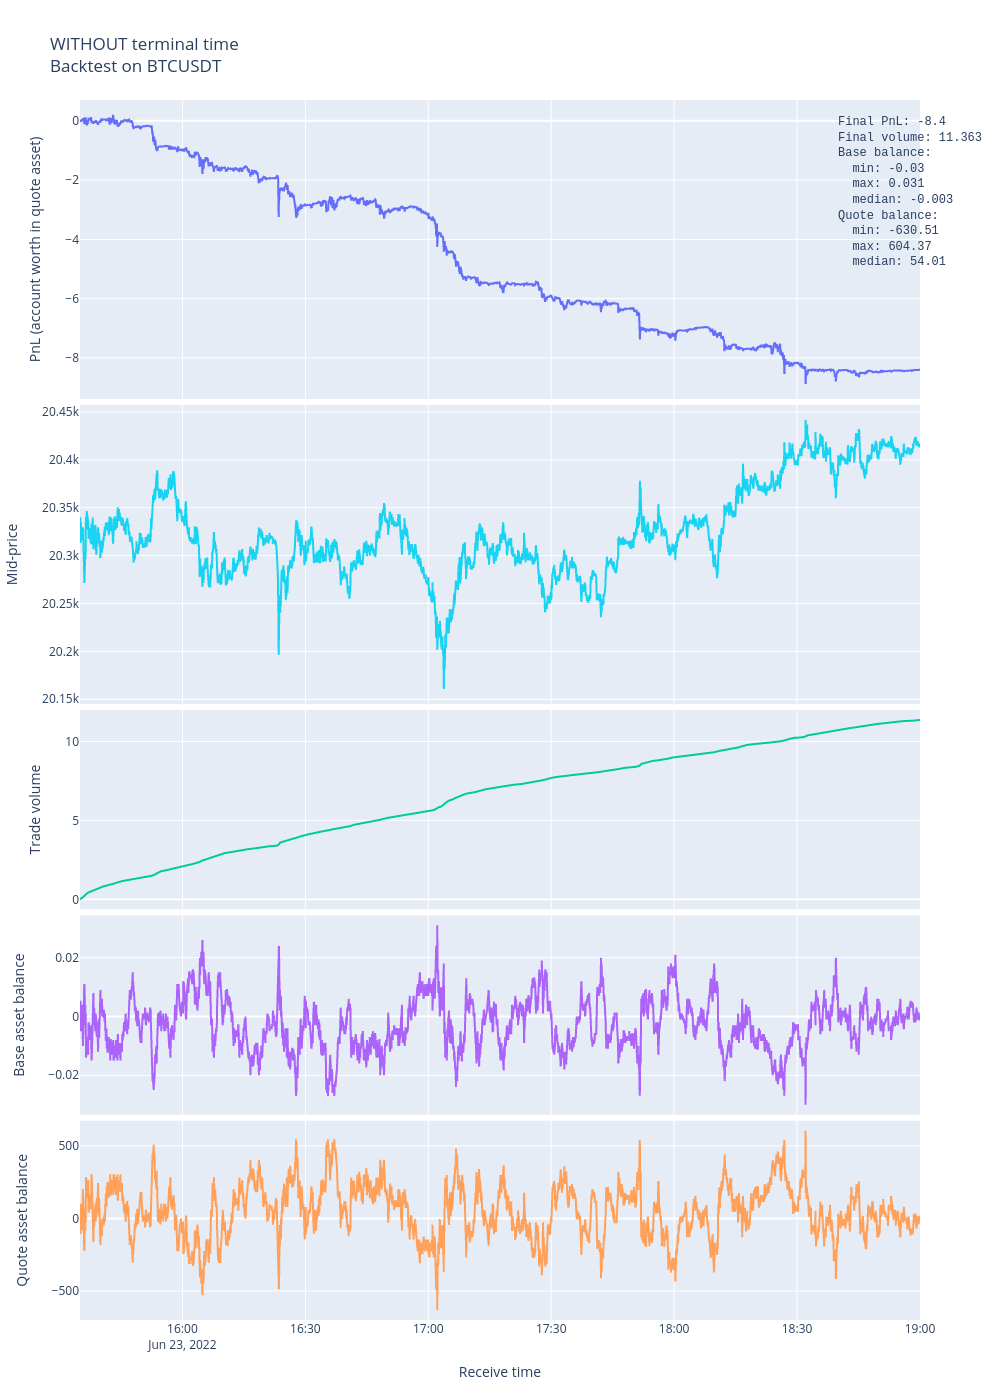

In [14]:
metrics_without, metrics_num_without = backtest(md, sim_params, {**strat_params, 'terminal_time': False}, fee=FEE)
fig = plot_metrics(metrics_without[::60], metrics_num_without, asset='BTCUSDT', title='WITHOUT terminal time')
fig.show(renderer='png')

  0%|          | 0/1040571 [00:00<?, ?it/s]

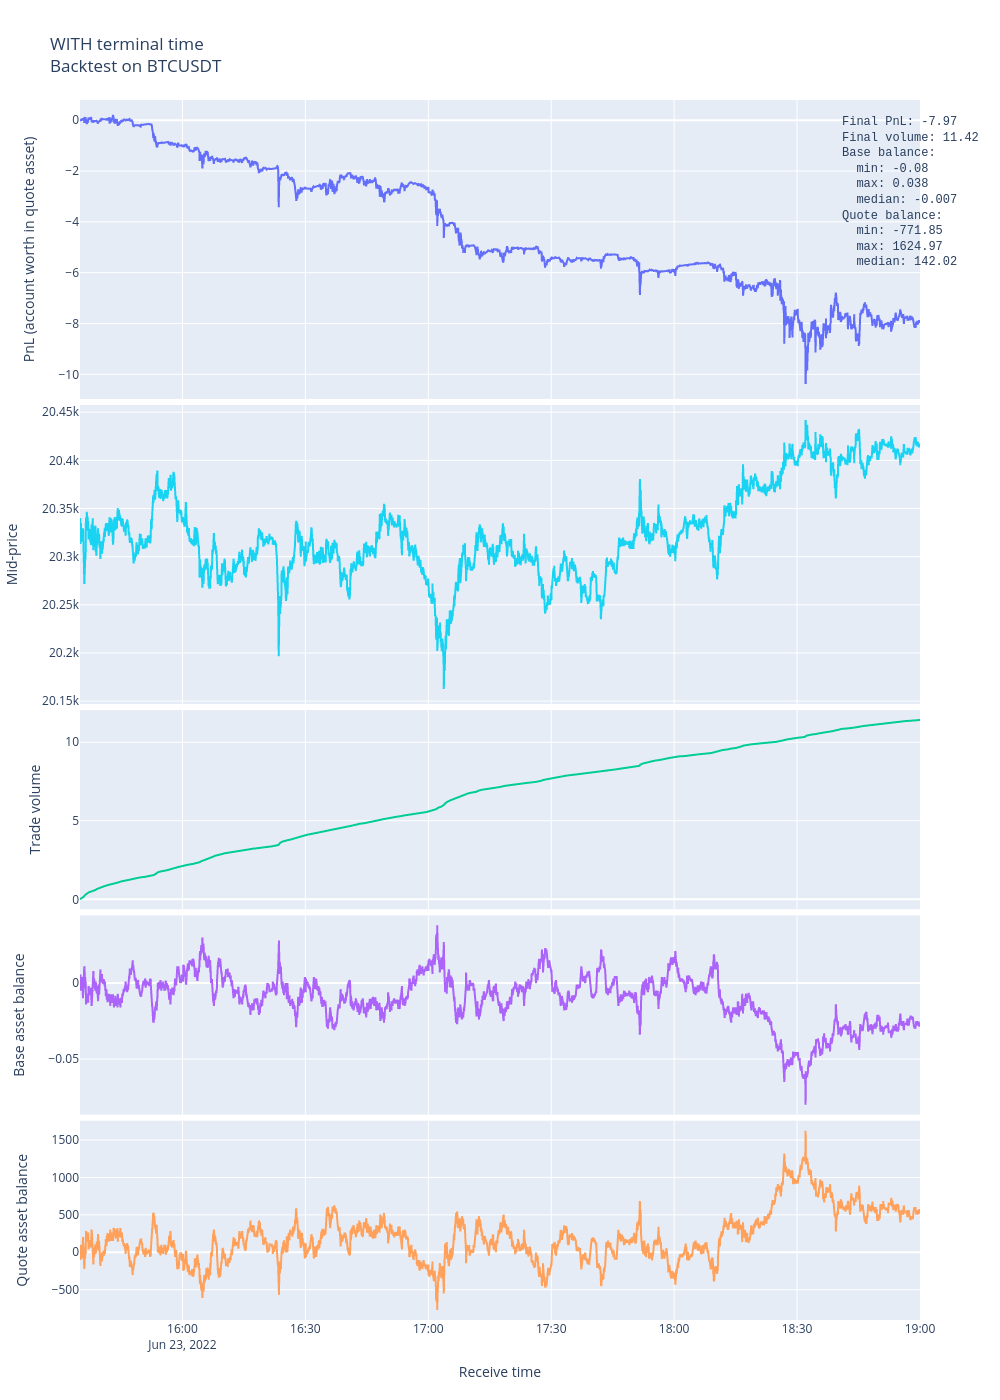

In [15]:
metrics_with, metrics_num_with = backtest(md, sim_params, {**strat_params, 'terminal_time': True}, fee=FEE)
fig = plot_metrics(metrics_with[::60], metrics_num_with, asset='APPLUSDT', title=f'WITH terminal time')
fig.show(renderer='png')

As the terminal time approaches, the strategy becomes less market-neutral and the balances can diverge farther from zero. There is little reason to use the terminal time parameter for APPLUSDT Perpetual Futures, because it does not have actual terminal time.

## Compare strategy performance with and without fees

In [16]:
MIN_TS = pd.Timestamp('2022-06-23 15:35:00')
MAX_TS = pd.Timestamp('2022-06-23 19:00:00')

In [17]:
md = load_md_from_file(MARKET_DATA_PATH, MIN_TS, MAX_TS)

In [18]:
sim_params = {
    'execution_latency': 10_000_000,
    'md_latency': 10_000_000
}
strat_params = {
    'gamma': 0.01,
    'k': 0.8,
    'sigma': 1,
    'terminal_time': False,
    'adjust_delay': 100_000_000,
    'order_size': 0.001,
    'min_order_size': 0.001,
    'precision': 2
}

In [19]:
sim = Sim(md, **sim_params)
strategy = StoikovStrategy(sim, **strat_params)
_, _, updates_list, _ = strategy.run()

  0%|          | 0/1040571 [00:00<?, ?it/s]

In [20]:
def compare_fees(updates_list, fee):
    metrics = get_metrics(updates_list, fee=fee)
    metrics_numeric = get_metrics_numeric(metrics)
    fig = plot_metrics(metrics[::60], metrics_numeric, asset='APPLUSDT', title=f'fee: {fee*100}%')
    return fig

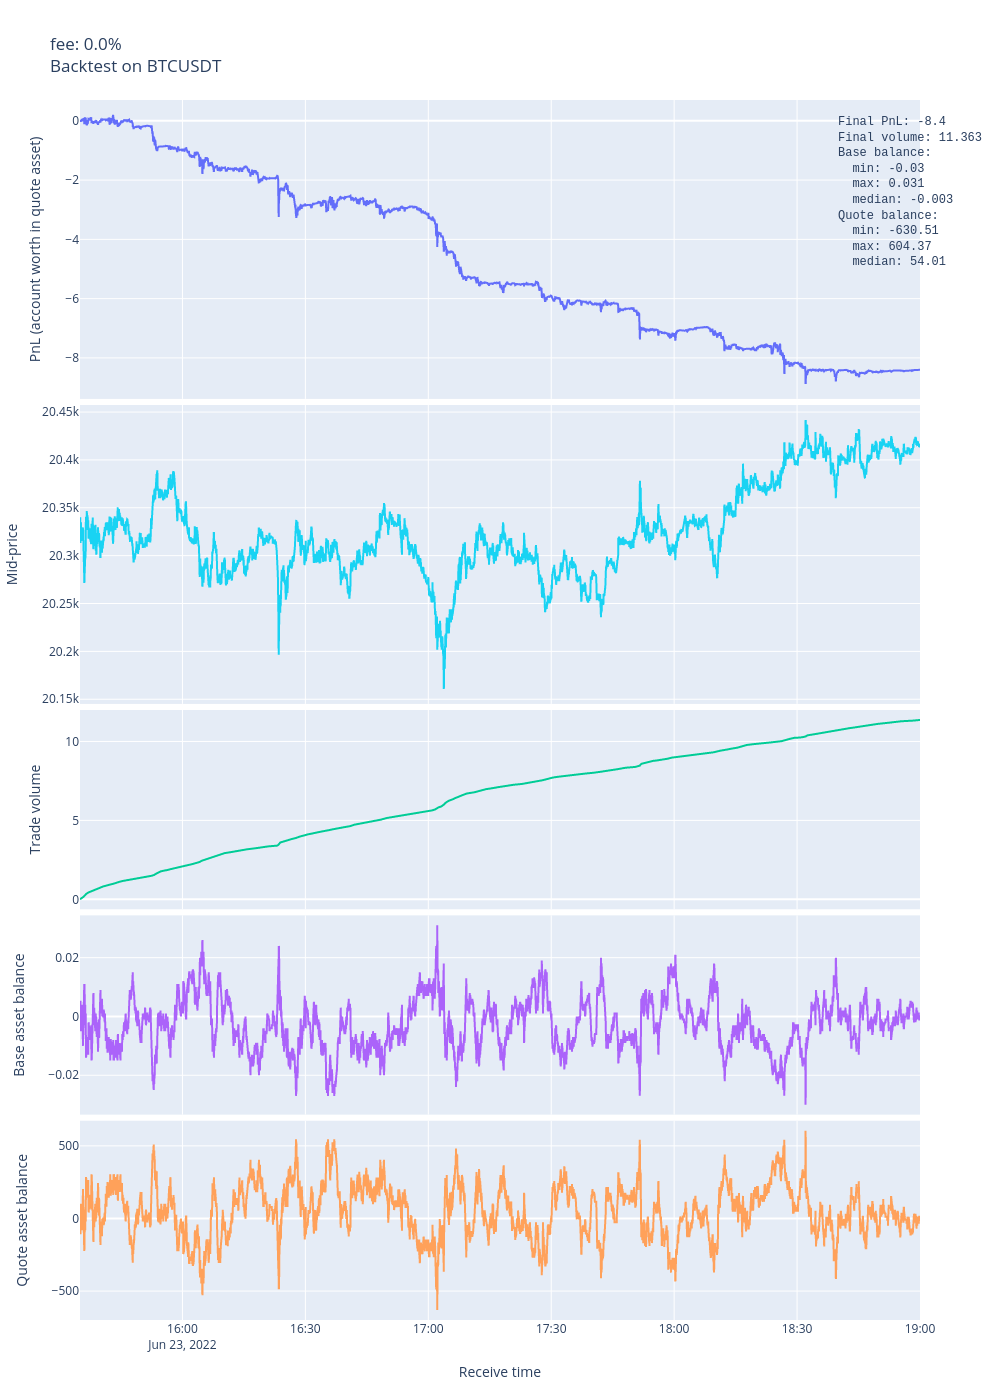

In [21]:
compare_fees(updates_list, 0.0).show(renderer='png')

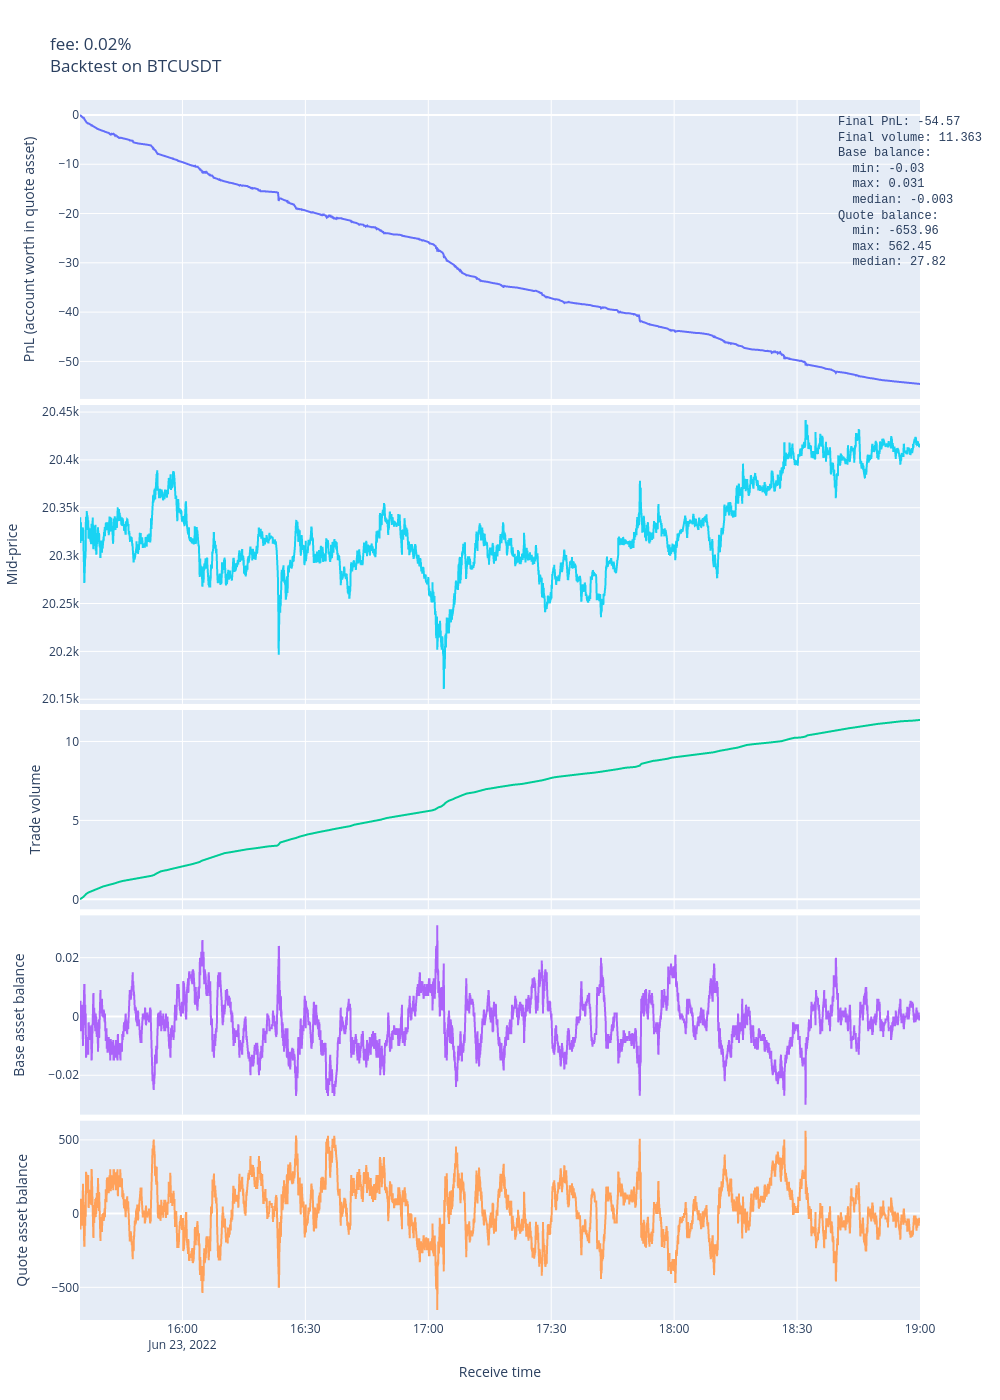

In [22]:
compare_fees(updates_list, 0.0002).show(renderer='png')

Fees increase the losses, but they are still small comparing to the trading volume.

## Compare simulations with different values of $\gamma$

In [23]:
MIN_TS = pd.Timestamp('2022-06-23 15:35:00')
MAX_TS = pd.Timestamp('2022-06-23 19:00:00')

In [24]:
md = load_md_from_file(MARKET_DATA_PATH, MIN_TS, MAX_TS)

In [25]:
sim_params = {
    'execution_latency': 10_000_000,
    'md_latency': 10_000_000
}
strat_params = {
    'gamma': None,  # Will be set in the loop
    'k': 0.8,
    'sigma': 1,
    'terminal_time': False,
    'adjust_delay': 100_000_000,
    'order_size': 0.001,
    'min_order_size': 0.001,
    'precision': 2
}
FEE = 0.0

In [ ]:
metrics_list = []
metrics_numeric_list = []
fig_list = []
GAMMA_VALUES = [0.002, 0.005, 0.04, 0.01, 0.1, 0.5, 1, 2, 4]

idx = 0
for gamma in tqdm(GAMMA_VALUES):
    strat_params['gamma'] = gamma
    metrics, metrics_numeric = backtest(md, sim_params, strat_params, fee=FEE)
    metrics_list.append(metrics)
    metrics_numeric_list.append(metrics_numeric)

    fig = plot_metrics(metrics[::60], metrics_numeric, asset='BTCUSDT',
                       title=f'gamma: {strat_params["gamma"]}, k: {strat_params["k"]}, '
                             f'sigma: {strat_params["sigma"]}, fee: {FEE*100}%')
    img_name = f'gamma_{gamma}.png'
    fig.write_image(f'backtesting_results/0{idx+1}_{img_name}')
    idx += 1

with open('backtesting_results/input_params.yaml', 'w') as f:
    strat_params_copy = copy.deepcopy(strat_params)
    strat_params_copy['gamma'] = GAMMA_VALUES
    params = {
        'Simulator parameters': sim_params,
        'Strategy parameters': strat_params_copy,
        'Maker/taker fee': FEE
    }
    f.write(yaml.dump(params, default_flow_style=False, sort_keys=False))

The results are saved in `backtesting_results`. Pre-computed results for this notebook can be found in `backtesting_resultsing/compare_gamma`.

With decrease of risk-aversity parameter $\gamma$, PnL increases, but the balances start to diverge farther from zero, and the trading volume decreases.
